# Loading MNIST DATA

In [44]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])  # 텐서화로 바꿈

# Download and load the training data
# 이미지 폴더를 대체(파이토치의 기본적인 데이터셋을 가져옴)
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)

In [46]:
trainset  # 6만개의 데이터 중 1000개씩 배치 사이즈

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\이예주/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [47]:
# 'trainloader'의 1000개씩 배치가 출력 / 이미지, 레이블이 나옴
images, labels = next(iter(trainloader))

In [48]:
# 1000개의 배치의 1x28x28  / 1x28x28 의 그림이 1000개 있다.(배치가 1000이기 때문에)
# 1인 이유는 흑백이여서.(흑백은 채널이 하나)

images.shape   

torch.Size([1000, 1, 28, 28])

In [49]:
torch.mean(images)  # 평균

tensor(0.1302)

In [50]:
torch.std(images)  # 표준편차

tensor(0.3076)

In [51]:
# Define a transform to normalize the data
# transform을 추가로 정의 (Normalize)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.13), (0.3)),  # transforms.Normalize(평균, 표준편차)
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [52]:
images, labels = next(iter(trainloader))

In [53]:
images.shape

torch.Size([64, 1, 28, 28])

In [54]:
# images.shape[0] -> 64는 그대로 둔다
# 1, 28, 28 차원을 일렬로 펴서 벡터화로 만든다. 1x28x28  -> (64, 784)

Xsample = images.reshape(images.shape[0], -1)

#### 각 픽셀을 feature로 취급한다.

In [55]:
# 784짜리 벡터가 우리 network의 입력이 된다.
# 784개의 feature(각 픽셀)이 64개가 있는 것이다. -> 784짜리가 입력이 된다.
Xsample.shape  

torch.Size([64, 784])

### Problem 1: Constructing the network model

`FNC` class를 정의하고 `model`을 생성하세요:

- input layer
  - number of input features를 hidden unit 128개로 선형변환 및 ReLU activation function
- Hidden layer
  - 128 hidden unit을 64개 hidden unit으로 선형변환 및 ReLU
- Output layer
  - 64개 hidden unit을 10개 class로 분류하기 위한 output layer
  - 최종 layer의 activation은 없음 (linear layer)

In [56]:
class FCN(nn.Module):
    # 답작성
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(True),
                      nn.Linear(128, 64),
                      nn.ReLU(True),
                      nn.Linear(64, 10)   # 마지막 layer는 Linear layer로 
                                          # 우리가 분류해야 하는 숫자가 0~9까지 10개
        )
        
    def forward(self, x):
        return self.seq(x)
    

In [57]:
model = FCN()

## Loss Functions in PyTorch

* 다음 과정으로, Pytorch에서 loss를 어떻게 연산하는지 배워보죠
* `nn` module에서 다양한 loss function을 제공하는데, 예를 들면 `nn.CrossEntropyLoss`와 같은 함수가 있습니다
    * 보통 관습적으로 loss function은 `critertion`이라는 변수로 받습니다 (`loss_function`등도 당연히 사용 가능합니다)
* 지난 시간에 MNIST 문제는 확률 분포를 output으로 받는 것이 필요하다고 (또는 자연스러운 선택 임을) 학습했습니다 
* 이런 확률 분포를 output으로 받는 경우 대응되는 좋은 loss function이 cross entropy입니다 (이론 강의에서 cross entropy가 무엇을 의미하는지 설명한 부분을 복습 해보세요)

* Cross entropy의 정의는 
\begin{align*}
 J(\theta) &=-\frac{1}{m}\sum_{i=1}^m P(y^{(i)}|x^{(i)})\log(Q(y^{(i)}|x^{(i)}))
\end{align*}
* 위 식은 두 확률 분포의 "거리"를 표현하는 식이라고 배웠습니다
* 위에서 $P(y|x)$는 $y$의 label을 one hot coding 한 vector이고 $Q(y|x)$는 softmax를 취한 network output입니다
* One hot coding은 label이 1이면 첫번째 자리만 '1'이고 나머지는 영인 벡터, label이 $k$이면 $k$ 번째 자리만 '1'이고 나머지는 0인 벡터입니다

* 예를들어서 label이 2에 대한 one hot encoding
\begin{align*}
y_\textrm{one_hot}(2) &= \begin{array}{cccccc}
[0 & 0 & 1 & \cdots & 0]
\end{array}
\end{align*}

* 위 cross entropy 식에 대응 하는 방식은, label이 2라고 가정했을 때 분포는:
\begin{align*}
P(y|x) = y_\textrm{one_hot}(2), \quad P(2|x) = (y_\textrm{one_hot}(2))_2
\end{align*}

* 또한, neural network의 마지막 linear layer의 output 값이 $z$라고 할때,
\begin{align*}
Q(y=2|x) = \sigma(z_2) = \cfrac{\exp(z_2)}{\sum_k^K{\exp(z_k)}}
\end{align*}

![Classnote](https://drive.google.com/uc?export=download&id=17hcl4RJne65Vd17gKM8XKUTjYlqyFIY5)

* pytorch에서 이를 수행하기 위해서 criterion을 `nn.CrossEntropyLoss`로 생성하고, network의 예측 값과, 실제 label 값을 입력으로 loss를 계산합니다
  * 본 과정은 차근차근 설명하겠습니다
* 그 전에 Pytorch에서 cross entropy 함수를 어떻게 적용하는지 먼저 이해할 필요가 있습니다 (중요합니다!!!)
  * [Pytorch.org `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)를 살펴보면

> This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
>
> The input is expected to contain scores for each class.

* `nn.CrossEntropyLoss`는 `nn.LogSoftmax()`와 `nn.NLLLoss()` 하나의 class에서 수행한다고 되어 있습니다. 
* 두번째 줄에서 NLLLoss 는 negative log likelihood loss 입니다 

* 이게 의미하는 바가 무엇이냐면, network의 output을 softmax function을 적용하여 출력하지 말고, softmax는 loss function에서 계산한다는 뜻입니다
* 이렇게 구현한 이유는, 확률값이 작을 수 있어서 computation precision error를 방지하기 위해서 그냥 raw output 값을 받고, loss function에서 log(prob) 형태로 연산하도록 모듈을 구성하였습니다

* 아래 코드를 보면 조금 더 이해가 될 것이라고 생각합니다


In [58]:
criterion = nn.CrossEntropyLoss()
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.reshape(images.shape[0], -1)

# Forward pass, get our log-probabilities(모델 예측값 계산)
# logits : 최종 Linear Layer로 나온 output / activation 하기 전 (배치사이즈가 64개 였기 때문에, logit도 총 64개)
logits = model(images)

# Calculate the loss with the logps and the labels(손실값 계산)
# criterion에 (softmax를 취하지 않은)logits와 labels를 넣어주면 (CrossEntropy)loss를 계산해준다.
# 이유 : 확률값으로 변형을 하면 그 값이 굉장히 작은 값일 때가 있다. -> 프로그램 상의 수치적 문제

loss = criterion(logits, labels)    # 한 배치에 대한 loss

print(loss)

tensor(2.3222, grad_fn=<NllLossBackward0>)


* 다시 한번 상기하기   
image 받은거(64개의 배치를)를 784개의 일렬로 핀 벡터들의 샘플들을   
model(클래스변수)에 집어 넣어서, 최종 선형 layer를 통과한 출력들이 쭉 나온 것이다. -> logits   
이것을 가지고 softmax를 취한 확률 값으로 바꿔보자.

### logits는 softmax함수를 취하기 전의 Linear layer의 출력값(동그라미수)이다.

In [59]:
logits.shape  # 입력 feature 64개, 최종 layer의 뉴런 10개

torch.Size([64, 10])

In [60]:
labels.shape  # 64개의 정답

torch.Size([64])

In [61]:
labels  # 첫번째 row의 정답은 7, 두번째는 8, ...

tensor([7, 8, 5, 1, 7, 4, 8, 7, 6, 7, 2, 1, 2, 3, 6, 2, 0, 8, 6, 7, 6, 0, 4, 3,
        8, 7, 4, 3, 7, 4, 2, 0, 2, 6, 3, 3, 7, 6, 6, 2, 5, 3, 1, 5, 9, 5, 7, 3,
        7, 6, 7, 0, 9, 8, 8, 5, 4, 8, 9, 7, 2, 9, 9, 0])

### softmax를 취해야 확률이 된다. -> logit으로부터 softmax를 취해야 하고, log까지 해주면 모델 output의 확률이 된다

### Problem 2: Implement softmax

다음 `softmax` 함수를 만드세요

- `softmax(x)`
- `input`: (batchsize, num_class)의 최종 linear layer output
- `output`: `softmax` 취한 output이 (batchsize, softmaxoutput) 차원으로 정렬

- 유용할 수 있는 함수:
    - `torch.sum`
    - `torch.exp`
    - broadcasting 사용 (reshape)

In [62]:
logits.shape

torch.Size([64, 10])

In [63]:
torch.exp(logits)  # 모든 원소들에게 exp를 씌운 것

tensor([[0.9190, 1.0612, 1.1013, 1.0445, 1.1478, 1.0248, 1.2038, 1.0130, 0.9161,
         1.0247],
        [0.8939, 1.1716, 1.2619, 1.0551, 1.0577, 1.0014, 1.2770, 1.0570, 0.7559,
         1.0498],
        [0.9347, 1.2127, 1.2779, 1.1197, 1.1438, 0.9626, 1.3058, 0.9809, 0.9099,
         1.0121],
        [1.0082, 1.1063, 1.1315, 0.9949, 1.1663, 1.0294, 1.1761, 1.0321, 0.9270,
         1.0268],
        [1.0467, 1.0665, 1.0680, 1.0183, 1.1728, 1.0906, 1.2256, 0.9787, 0.9220,
         1.0428],
        [0.8497, 1.1753, 1.2371, 1.1082, 1.0661, 1.0060, 1.1578, 1.0731, 0.8450,
         1.0126],
        [0.8677, 1.2165, 1.2251, 1.0571, 1.1508, 0.9523, 1.3458, 1.0653, 0.8091,
         1.0096],
        [0.9629, 1.1114, 1.0580, 1.0555, 1.1694, 1.0086, 1.1745, 0.9525, 0.8907,
         0.9944],
        [0.8319, 1.1549, 1.1657, 0.9814, 1.0200, 1.1339, 1.1819, 1.2370, 0.8861,
         0.9749],
        [0.9489, 1.0480, 1.1380, 1.0941, 1.1933, 0.9765, 1.1381, 1.0334, 0.8114,
         1.0260],
        [0

In [64]:
# 각 row별로 exp취한 것들의 합
torch.sum(torch.exp(logits), axis = 1).reshape(-1,1)  # axis = 1 : 좌에서 우로(행으로) 더한다.

tensor([[10.4561],
        [10.5815],
        [10.8601],
        [10.5987],
        [10.6319],
        [10.5311],
        [10.6993],
        [10.3779],
        [10.5675],
        [10.4078],
        [10.3748],
        [10.5051],
        [10.5290],
        [11.0259],
        [10.6988],
        [10.4007],
        [10.8085],
        [10.7255],
        [10.6476],
        [10.4457],
        [10.6671],
        [10.6958],
        [10.4988],
        [11.1070],
        [10.4852],
        [10.4524],
        [10.7999],
        [10.4495],
        [10.8184],
        [10.6214],
        [10.6691],
        [10.6976],
        [10.8856],
        [10.6961],
        [11.1695],
        [10.6344],
        [10.5057],
        [10.0719],
        [10.6498],
        [10.7123],
        [10.6470],
        [10.7248],
        [10.2254],
        [10.4216],
        [10.6835],
        [10.7256],
        [10.6957],
        [10.7148],
        [10.6682],
        [10.6082],
        [10.5734],
        [10.7317],
        [10.

In [67]:
torch.exp(logits) / torch.sum(torch.exp(logits), axis = 1).reshape(-1,1)

tensor([[0.0879, 0.1015, 0.1053, 0.0999, 0.1098, 0.0980, 0.1151, 0.0969, 0.0876,
         0.0980],
        [0.0845, 0.1107, 0.1193, 0.0997, 0.1000, 0.0946, 0.1207, 0.0999, 0.0714,
         0.0992],
        [0.0861, 0.1117, 0.1177, 0.1031, 0.1053, 0.0886, 0.1202, 0.0903, 0.0838,
         0.0932],
        [0.0951, 0.1044, 0.1068, 0.0939, 0.1100, 0.0971, 0.1110, 0.0974, 0.0875,
         0.0969],
        [0.0984, 0.1003, 0.1005, 0.0958, 0.1103, 0.1026, 0.1153, 0.0920, 0.0867,
         0.0981],
        [0.0807, 0.1116, 0.1175, 0.1052, 0.1012, 0.0955, 0.1099, 0.1019, 0.0802,
         0.0962],
        [0.0811, 0.1137, 0.1145, 0.0988, 0.1076, 0.0890, 0.1258, 0.0996, 0.0756,
         0.0944],
        [0.0928, 0.1071, 0.1020, 0.1017, 0.1127, 0.0972, 0.1132, 0.0918, 0.0858,
         0.0958],
        [0.0787, 0.1093, 0.1103, 0.0929, 0.0965, 0.1073, 0.1118, 0.1171, 0.0839,
         0.0923],
        [0.0912, 0.1007, 0.1093, 0.1051, 0.1147, 0.0938, 0.1094, 0.0993, 0.0780,
         0.0986],
        [0

In [78]:
# 답작성
# 각 row별로 softmax를 취해라.

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis = 1).reshape(-1,1)  # 브로드캐스팅 되어서 나눠진다.

In [79]:
ps = softmax(logits)
ps

tensor([[0.0879, 0.1015, 0.1053, 0.0999, 0.1098, 0.0980, 0.1151, 0.0969, 0.0876,
         0.0980],
        [0.0845, 0.1107, 0.1193, 0.0997, 0.1000, 0.0946, 0.1207, 0.0999, 0.0714,
         0.0992],
        [0.0861, 0.1117, 0.1177, 0.1031, 0.1053, 0.0886, 0.1202, 0.0903, 0.0838,
         0.0932],
        [0.0951, 0.1044, 0.1068, 0.0939, 0.1100, 0.0971, 0.1110, 0.0974, 0.0875,
         0.0969],
        [0.0984, 0.1003, 0.1005, 0.0958, 0.1103, 0.1026, 0.1153, 0.0920, 0.0867,
         0.0981],
        [0.0807, 0.1116, 0.1175, 0.1052, 0.1012, 0.0955, 0.1099, 0.1019, 0.0802,
         0.0962],
        [0.0811, 0.1137, 0.1145, 0.0988, 0.1076, 0.0890, 0.1258, 0.0996, 0.0756,
         0.0944],
        [0.0928, 0.1071, 0.1020, 0.1017, 0.1127, 0.0972, 0.1132, 0.0918, 0.0858,
         0.0958],
        [0.0787, 0.1093, 0.1103, 0.0929, 0.0965, 0.1073, 0.1118, 0.1171, 0.0839,
         0.0923],
        [0.0912, 0.1007, 0.1093, 0.1051, 0.1147, 0.0938, 0.1094, 0.0993, 0.0780,
         0.0986],
        [0

### Problem 3: Finding the Highest probability index

Sample별 예측 확률값을 통하여 가장 높은 확률 값 예측 받는 함수를 작성하세요.

`get_pred(ps)`
- `input`: sample 별 확률값을 (batchsize, class probabilities) 로 받음
- `output`: sample 별로 가장 높은 확률값의 index를 return

- 유용할 수 있는 함수
  - `torch.argmax`



In [87]:
def get_pred(ps):
    # 답작성
    return torch.argmax(ps, axis=1)  # 행별로 최댓값 인덱스를 뽑아준다.

In [80]:
torch.argmax(ps, axis=1)  # row별로 최댓값을 뽑아줌

tensor([6, 6, 6, 6, 6, 2, 6, 6, 7, 4, 6, 6, 6, 4, 6, 6, 4, 1, 6, 6, 2, 6, 2, 6,
        6, 4, 6, 2, 4, 6, 6, 6, 2, 6, 6, 2, 3, 2, 2, 6, 4, 2, 2, 2, 6, 6, 4, 6,
        4, 4, 6, 4, 2, 6, 1, 2, 2, 6, 4, 6, 6, 6, 6, 2])

# Calculating Gradients
이전까지는 forward pass를 하고, loss를 계산할 수 있게끔 만든 것.     
이제는 그레디언트를 구하고, 그것을 기반으로 SGD를 수행하는 것.(파라미터 업데이트)

In [82]:
# 모델의 weight들
# requires_grad=True : 그레이디언트를 weight라는 곳에 함께 저장하도록 되어있는 것.

model.seq[0].weight   

Parameter containing:
tensor([[-0.0175,  0.0172, -0.0244,  ..., -0.0226, -0.0034,  0.0185],
        [-0.0320, -0.0243,  0.0066,  ..., -0.0280, -0.0061,  0.0330],
        [-0.0053,  0.0166, -0.0070,  ...,  0.0260,  0.0227,  0.0013],
        ...,
        [-0.0277, -0.0350, -0.0320,  ..., -0.0118,  0.0139, -0.0076],
        [-0.0317,  0.0211,  0.0094,  ..., -0.0109,  0.0195, -0.0242],
        [-0.0277, -0.0300, -0.0278,  ...,  0.0051, -0.0206,  0.0003]],
       requires_grad=True)

그레디언트 : weight별로 loss함수를 편미분한 것. 때문에 각 weight들에 이것을 저장하고 있는 것이 편리하다.

In [81]:

print('Before backward pass: \n', model.seq[0].weight.grad)

# 전체 파라미터에 그레이디언트 구하기
# 한 배치에 대한 loss를 backward해서 그레디언트를 구했는데, 전체에 대해서 구해진다. -> pytorch!!
loss.backward()  

print('After backward pass: \n', model.seq[0].weight.grad)  # 각 weight에 대한 그레이디언트가 구해진다.

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        ...,
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002]])


## Training the network!


* 자, 그럼 network parameter에 대한 loss function의 gradient를 구했으니, 이제 최적화를 할 수 있습니다
* 최적화 기법은 SGD 이외에도 많으며 (SGD의 변형들임) [`optim` package](https://pytorch.org/docs/stable/optim.html)에서 찾아서 사용할 수 있습니다
* 예를 들어서 SGD는 `optim.SGD`를 통해서 불러올 수 있습니다
* 아래 예를 보죠

In [84]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)  # 모델의 모든 파라미터에 SGD를 적용.

* model.parameters()는 우리 network의 모든 training parameter이며, lr는 learning rate 입니다
* 자, 이제 traning에 필요한 모든 부분이 준비되었습니다
* 전체 데이터에 대한 training은 숙제로 하고, 한 batch만 수행하는 과정을 살펴보죠
* Pytorch에서 training의 전체 흐름은 다음과 같습니다:

1. Network에서 forward pass
2. Foward pass를 통해서 얻은 output을 활용하여 loss를 구한다
3. Gradient를 구하기 위해서 `loss.backward()`를 실행한다
4. Optimizer에서 weight를 한번 update 한다 (SGD의 경우 gradient에 대해서 한번 update)

**[중요]**
* 한가지 주의할 점은, 한 Parameter들에 대해서 gradient를 여러개 구해야하는 경우, (예, batch 처리) gradient 값들은 계속 추가적으로 저장됩니다
* 한번 parameter update가 끝났으면, gradient 값을 초기화해야, 새로운 batch에 대한 새 gradient 값을 계산 합니다
* 이를 위해서 batch 시작시에 `optimizer.zero_grad()`를 실행해줘야합니다

In [85]:
print('Initial weights - ', model.seq[0].weight)

images, labels = next(iter(trainloader))
images = images.reshape(images.shape[0], -1)

# Clear the gradients, do this because gradients are accumulated
# 그레이디언트도 업데이트 할 때마다 바뀐다.
# 그레이디언트는 weigh별로 저장되어 있다 -> 새로운 그레이디언트 구할 때, 그레이디언트를 초기화를 해줘야 한다.
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()   # 그래디언트 구해진 상태(그래디언트 구하기)
optimizer.step()  # 그래디언트에 맞춰서 한번 업데이트
 

print('Gradient -', model.seq[0].weight)  # weight가 변한 것을 볼 수 있음

Initial weights -  Parameter containing:
tensor([[-0.0175,  0.0172, -0.0244,  ..., -0.0226, -0.0034,  0.0185],
        [-0.0320, -0.0243,  0.0066,  ..., -0.0280, -0.0061,  0.0330],
        [-0.0053,  0.0166, -0.0070,  ...,  0.0260,  0.0227,  0.0013],
        ...,
        [-0.0277, -0.0350, -0.0320,  ..., -0.0118,  0.0139, -0.0076],
        [-0.0317,  0.0211,  0.0094,  ..., -0.0109,  0.0195, -0.0242],
        [-0.0277, -0.0300, -0.0278,  ...,  0.0051, -0.0206,  0.0003]],
       requires_grad=True)
Gradient - Parameter containing:
tensor([[-0.0174,  0.0173, -0.0243,  ..., -0.0225, -0.0033,  0.0186],
        [-0.0321, -0.0245,  0.0065,  ..., -0.0281, -0.0063,  0.0329],
        [-0.0053,  0.0166, -0.0070,  ...,  0.0260,  0.0227,  0.0013],
        ...,
        [-0.0277, -0.0350, -0.0320,  ..., -0.0118,  0.0139, -0.0076],
        [-0.0317,  0.0211,  0.0094,  ..., -0.0109,  0.0195, -0.0241],
        [-0.0276, -0.0300, -0.0278,  ...,  0.0052, -0.0205,  0.0004]],
       requires_grad=True)


#### 학습을 처음부터 끝까지 하는 과정

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 5
loss_epoch = []
acc_epoch = []

for e in range(epochs):
    print(f"------ Starting epoch: {e} --------")
    # loss, accuracy 초깃값 = 0
    running_loss = 0
    running_acc = 0
    
    # 총 60000(전체 데이터수) / 64(배치수)번 돈다.
    # 한번 for문 돌 때, images와 labels가 정해진 배치 수(64개씩)만큼씩 나온다
    for images, labels in trainloader: 
        images = images.reshape(images.shape[0], -1)
    
        logits = model(images)
        loss = criterion(logits, labels)  # loss만드는 과정
        
        optimizer.zero_grad()   # (꼭 해주기) / 그래디언트 초기화
        loss.backward()  # 그래디언트 만드는 과정
        optimizer.step() # SGD 과정 / 그레디언트 업데이트

        running_loss += loss.item()  # loss 변수에 들어있는 실제 loss값을 'running_loss'에 계속 더한다.
        ps = softmax(logits)  # logit에 소프트맥스를 취해서 확률로 바꿔줌
        pred = get_pred(ps)   # 확률의 최댓값 출력
        running_acc += torch.sum(pred==labels)/labels.shape[0]   # 몇 개 성공했는지의 수 / 배치 수 = 성공률
        
    # 에폭별 loss와 accuracy를 저장한다.           
    acc_epoch.append(running_acc/len(trainloader))    
    loss_epoch.append(running_loss/len(trainloader))
    print(f"Training loss: {loss_epoch[e]}")
    print(f"Training acc: {acc_epoch[e]}")

------ Starting epoch: 0 --------
Training loss: 0.10468797146408225
Training acc: 0.9703991413116455
------ Starting epoch: 1 --------
Training loss: 0.09647904845999121
Training acc: 0.972914457321167
------ Starting epoch: 2 --------
Training loss: 0.08927002751818502
Training acc: 0.9746968150138855
------ Starting epoch: 3 --------
Training loss: 0.08316171148728364
Training acc: 0.9764792323112488
------ Starting epoch: 4 --------
Training loss: 0.07745684346736176
Training acc: 0.9777784943580627


### 에폭별로 loss를 출력하는 그림
해석) loss가 점점 줄고 있기 때문에 에폭을 더 늘려야 한다. 더 좋은 성능을 볼 수 있기 때문.

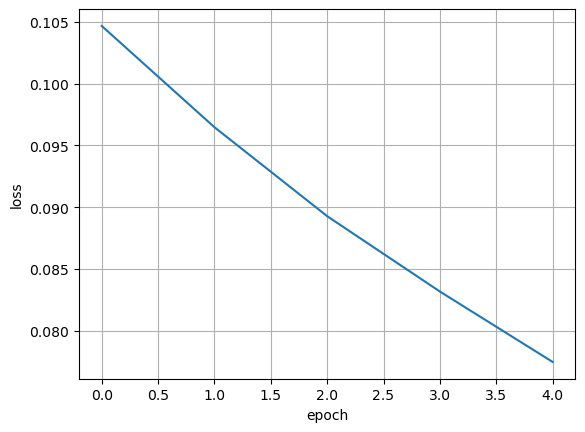

In [94]:
# loss가 점점 줄어드는 것을 볼 수 있다.

plt.plot(range(epochs), loss_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

### 에폭별로 accuarcy를 출력하는 그래프
해석) 아직 상승 기류가 있기 때문에 에폭을 더 늘려야 한다.

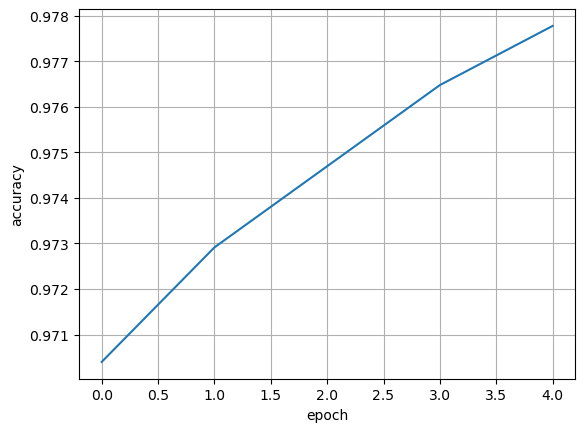

In [95]:
# 성공률
plt.plot(range(epochs), acc_epoch)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()

In [96]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

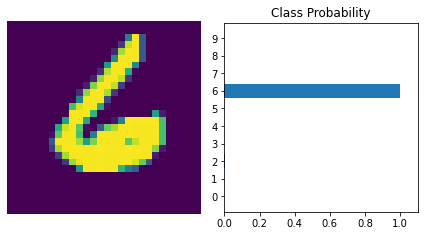

In [93]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = softmax(logps)
view_classify(img.view(1, 28, 28), ps)

TypeError: only size-1 arrays can be converted to Python scalars

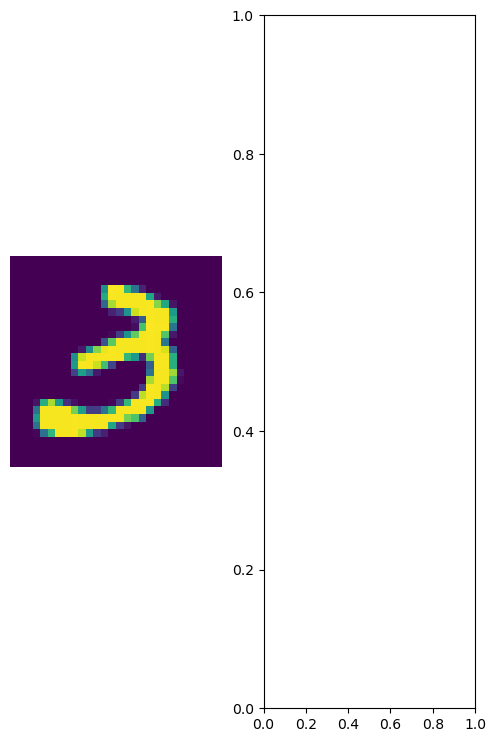

In [97]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = softmax(logps)
view_classify(img.view(1, 28, 28), ps)

In [98]:
labels[0]

tensor(3)